In [108]:
import numpy as np
from typing import Tuple
import numpy as np
from typing import Union, Optional, List, Any, Tuple, Callable, Dict
from itertools import product
import matplotlib.pyplot as plt

from scipy.sparse.linalg import cg
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.datasets import fetch_openml

# Classes Space

In [99]:
class SetOfPoints:
    """
    Represents a set of points in a d-dimensional space along with associated weights.

    Attributes:
        points (np.ndarray): A 2D numpy array of shape (n, d), where each row is a point in d-dimensional space.
        weights (np.ndarray): A 1D numpy array of shape (n,) representing the weight for each point.
    """

    def __init__(self, points: np.ndarray, weights: Optional[np.ndarray] = None):
        """
        Initializes a SetOfPoints instance.

        Args:
            points (np.ndarray): A (n, d) array of n points in d-dimensional space.
            weights (Optional[np.ndarray]): A (n,) array of weights corresponding to the points.

        Raises:
            ValueError: If points and weights have incompatible shapes.
        """
        
        if points.ndim != 2:
            raise ValueError("Points array must be 2-dimensional (n, d).")

        # Create weights if not given
        if weights is None:
            weights = np.ones(points.shape[0])

        weights /= np.sum(weights)        
        
        if weights.ndim != 1:
            raise ValueError("Weights array must be 1-dimensional (n,).")
        if points.shape[0] != weights.shape[0]:
            raise ValueError("Number of points and number of weights must be the same.")

        self.points = points
        self.shape = points.shape
        self.weights = weights

    def get_point(self, index: int) -> Tuple[np.ndarray, float]:
        """
        Returns a specific point and its weight.

        Args:
            index (int): Index of the point to retrieve.

        Returns:
            Tuple[np.ndarray, float]: A tuple containing the point (1D array) and its weight.
        """
        return self.points[index], self.weights[index]

    def normalize_weights(self) -> None:
        """
        Normalizes the weights so that they sum to 1.
        """
        total = np.sum(self.weights)
        if total == 0:
            raise ValueError("Total weight is zero. Cannot normalize.")
        self.weights = self.weights / total

    def subset(self, indices: np.ndarray) -> "SetOfPoints":
        """
        Returns a new SetOfPoints object containing only the selected indices.

        Args:
            indices (np.ndarray): An array of indices to include in the new subset.

        Returns:
            SetOfPoints: A new SetOfPoints object with selected points and weights.
        """
        return SetOfPoints(self.points[indices], self.weights[indices])

    def __len__(self) -> int:
        """
        Returns the number of points in the set.

        Returns:
            int: Number of points.
        """
        return self.points.shape[0]

    def dimension(self) -> int:
        """
        Returns the dimensionality of the points.

        Returns:
            int: The dimension (d) of each point.
        """
        return self.points.shape[1]

In [103]:
class Problem:
    """
    Represents a kernel-based resistance model over a set of points with grounding.

    Attributes:
        points (SetOfPoints): The points object.
        c (float): Kernel width parameter used in the Gaussian kernel.
        r (float): Resistance to ground.
    """

    def __init__(self, points: SetOfPoints, r: float):
        """
        Initializes a Problem instance.

        Args:
            points (np.ndarray): A (n, d) array of points.
            r (float): Resistance to the ground.

        Raises:
            ValueError: If input dimensions are incorrect or parameters are non-positive.
        """
        if r <= 0:
            raise ValueError("Ground resistance (r) must be positive.")

        self.points = points
        self.r = r

    def calcResistanceMatrix(self, k: int = 10, sparse: bool = True) -> Union[np.ndarray, csr_matrix]:
        """
        Calculates the (n+1)x(n+1) resistance matrix using k-nearest neighbors.
    
        Args:
            k (int): Number of nearest neighbors for sparse approximation.
            sparse (bool): Whether to return a sparse matrix.
    
        Returns:
            Union[np.ndarray, csr_matrix]: (n+1)x(n+1) resistance matrix.
        """
        X = self.points.points  # Assumes SetOfPoints instance
        n = X.shape[0]
    
        # Use NearestNeighbors to find k neighbors (including self, but we will exclude self manually)
        nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)
        distances, indices = nbrs.kneighbors(X)
    
        # Build the resistance (affinity) matrix as sparse
        kernel = lil_matrix((n, n))
    
        for i in range(n):
            for j_idx, dist in zip(indices[i][1:], distances[i][1:]):  # skip self (first entry)
                # Unweighted NN
                weight = 1.0 / k
                # Weighted within nearest neighbor
                # weight = np.exp(-dist ** 2 / (self.c ** 2))
                kernel[i, j_idx] = weight
                kernel[j_idx, i] = weight  # symmetric
    
        # Ground node connection
        ground_column = np.full((n, 1), 1.0 / self.r)
        ground_row = ground_column.T
    
        # Convert kernel to CSR and build full matrix
        kernel = kernel.tocsr()
    
        from scipy.sparse import hstack, vstack
    
        if sparse:
            # Build (n+1)x(n+1) matrix
            last_row = csr_matrix(np.append(ground_row, 1.0 / self.r))
            full_matrix = vstack([
                hstack([kernel, csr_matrix(ground_column)]),
                last_row
            ])
            return full_matrix
    
        else:
            dense_kernel = kernel.toarray()
            kernel_with_ground = np.block([
                [dense_kernel,     ground_column],
                [ground_row, np.array([[1.0 / self.r]])]
            ])
            return kernel_with_ground

In [70]:
class Landmark:
    """
    Represents a location in the dataset where a voltage will be applied.

    The `index` can refer either to an individual datapoint or a partition center.
    """

    def __init__(self, index: int, voltage: float) -> None:
        """
        Initializes a Landmark.

        Args:
            index (int): Index of the datapoint or partition center.
            voltage (float): Voltage to be applied at the specified index.
        """
        self.index = index
        self.voltage = voltage

    @staticmethod
    def createLandmarkClosestTo(
        data: List[Any],
        point: Any,
        voltage: float,
        distanceFn: Optional[object] = None,
        ignore: List[int] = []
    ) -> "Landmark":
        """
        Creates a Landmark at the index of the datapoint in `data` closest to `point`.

        Args:
            data (List[Any]): The dataset to search over.
            point (Any): The reference point to find the closest datapoint to.
            voltage (float): The voltage to assign to the resulting Landmark.
            ignore (List[int], optional): List of indices to skip during the search. Defaults to empty list.

        Returns:
            Landmark: A Landmark instance corresponding to the closest datapoint.
        """

        most_central_index = 0
        mindist = np.linalg.norm(data[0] - point)

        for index in range(1, len(data)):
            if index in ignore:
                continue

            dist = np.linalg.norm(data[index] - point)
            if dist < mindist:
                most_central_index = index
                mindist = dist

        return Landmark(most_central_index, voltage)

In [110]:
class Solver:
    """
    Solves for voltage distributions across a set of points in a resistance network.

    Given a problem with defined resistances and a set of landmarks with fixed voltages,
    this class computes the approximate voltages at all other points.

    Attributes:
        problem (Problem): The resistance network model.
    """

    def __init__(self, problem):
        """
        Initializes the solver with a given problem.

        Args:
            problem (Problem): The problem instance defining the resistance matrix.
        """
        self.problem = problem

    def approximate_voltages(self, landmarks: List['Landmark'], max_iters: int = 100, tol: float = 1e-6) -> np.ndarray:
        """
        Computes approximate voltages for all points in the network given landmark constraints.

        Args:
            landmarks (List[Landmark]): List of Landmark instances with indices and voltage values.
            max_iters (int): Maximum number of iterations for the solver.
            tol (float): Tolerance for convergence.

        Returns:
            np.ndarray: Array of voltages of size (n,) where n is the number of points.
        """
        n = self.problem.points.shape[0]
        R = self.problem.calcResistanceMatrix()  # (n+1)x(n+1) matrix
        R = R.tocsr() if not isinstance(R, csr_matrix) else R

        R_n = R[:-1, :-1]
        ground_column = R[:-1, -1].toarray().flatten()

        # Initialize voltage vector and fixed mask
        V = np.zeros(n)
        fixed_mask = np.zeros(n, dtype=bool)
        fixed_values = {}

        for landmark in landmarks:
            fixed_mask[landmark.index] = True
            fixed_values[landmark.index] = landmark.voltage
            V[landmark.index] = landmark.voltage

        # Identify free indices and adjust linear system
        free_indices = np.where(~fixed_mask)[0]
        A = R_n[free_indices][:, free_indices]

        b = ground_column[free_indices].copy()
        if any(fixed_mask):
            fixed_indices = np.where(fixed_mask)[0]
            fixed_vector = np.array([fixed_values[i] for i in fixed_indices])
            b -= R_n[free_indices][:, fixed_indices] @ fixed_vector

        # Solve the system
        V_free, _ = cg(A, b, maxiter=max_iters)
        V[free_indices] = V_free

        return V

In [74]:
class Visualization:
    """
    Visualization utilities for displaying voltage maps on 2D point sets.

    Primarily intended to visualize outputs from the Solver.
    """

    @staticmethod
    def plot_voltage_map(points: np.ndarray, voltages: np.ndarray, title: str = "Voltage Map") -> None:
        """
        Plots a 2D scatter plot where point colors correspond to voltage values.

        Args:
            points (np.ndarray): n x 2 array of 2D coordinates.
            voltages (np.ndarray): 1D array of voltages, same length as number of points.
            title (str): Title for the plot.
        """
        if points.shape[1] != 2:
            raise ValueError("Visualization only supports 2D data.")

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(points[:, 0], points[:, 1], c=voltages, cmap='viridis', s=30, edgecolor='k')
        plt.colorbar(scatter, label='Voltage')
        plt.title(title)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def compare_voltage_maps(points: np.ndarray, voltage_maps: List[np.ndarray], titles: List[str]) -> None:
        """
        Plots multiple voltage maps side-by-side for comparison.

        Args:
            points (np.ndarray): n x 2 array of 2D coordinates.
            voltage_maps (List[np.ndarray]): List of 1D voltage arrays.
            titles (List[str]): Titles for each subplot.
        """
        if points.shape[1] != 2:
            raise ValueError("Visualization only supports 2D data.")
        if len(voltage_maps) != len(titles):
            raise ValueError("Length of voltage_maps and titles must match.")

        n = len(voltage_maps)
        fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
        if n == 1:
            axes = [axes]

        for i in range(n):
            sc = axes[i].scatter(points[:, 0], points[:, 1], c=voltage_maps[i], cmap='viridis', s=30, edgecolor='k')
            axes[i].set_title(titles[i])
            axes[i].set_xlabel("X")
            axes[i].set_ylabel("Y")
            axes[i].grid(True)
            plt.colorbar(sc, ax=axes[i], label='Voltage')

        plt.tight_layout()
        plt.show()

In [75]:
class Map:
    """
    Represents a collection of voltage solutions (voltage maps), one for each landmark.

    Each voltage map corresponds to the solution from applying a Solver to a Problem with a specific Landmark.
    """

    def __init__(self) -> None:
        """
        Initializes an empty Map.
        """
        self.voltage_maps: Dict[int, np.ndarray] = {}  # Maps landmark index to voltage array
        self.landmarks: List[int] = []                # Ordered list of landmark indices
        self.shape: tuple = ()

    def add_solution(self, landmark_index: int, voltages: np.ndarray) -> None:
        """
        Adds a voltage map corresponding to a specific landmark.

        Args:
            landmark_index (int): The index of the landmark used in the problem.
            voltages (np.ndarray): The computed voltage map for that landmark.
        """
        self.voltage_maps[landmark_index] = voltages
        self.landmarks.append(landmark_index)
        if not self.shape:
            self.shape = voltages.shape

    def get_solution(self, landmark_index: int) -> np.ndarray:
        """
        Retrieves the voltage map for a specific landmark.

        Args:
            landmark_index (int): Index of the desired landmark.

        Returns:
            np.ndarray: The voltage map.
        """
        return self.voltage_maps[landmark_index]

    def all_solutions(self) -> np.ndarray:
        """
        Retrieves all voltage maps as a stacked 2D array (landmarks x points).

        Returns:
            np.ndarray: 2D array of shape (num_landmarks, num_points)
        """
        return np.stack([self.voltage_maps[lm] for lm in self.landmarks], axis=0)

    def __len__(self) -> int:
        return len(self.voltage_maps)

    def __repr__(self) -> str:
        return f"<Map: {len(self)} landmarks, voltage map shape={self.shape}>"

    @staticmethod
    def from_problem_and_landmarks(problem, landmarks: List["Landmark"], solver_cls) -> "Map":
        """
        Constructs a Map by solving the Problem for each landmark.

        Args:
            problem: An instance of a Problem class.
            landmarks (List[Landmark]): List of Landmark instances.
            solver_cls: A Solver class that takes a problem and a landmark.

        Returns:
            Map: A populated Map instance.
        """
        voltage_map = Map()
        for landmark in landmarks:
            solver = solver_cls(problem, landmark)
            voltages = solver.approximate_voltages()
            voltage_map.add_solution(landmark.index, voltages)
        return voltage_map

In [89]:
class KMeans:
    """
    Streaming KMeans clustering algorithm that creates a weighted partition
    (SetOfPoints) from a data file or large dataset.

    This is suitable for large-scale or streaming data, where full dataset
    access is not feasible.
    """

    def __init__(self, k: int):
        """
        Initializes the streaming KMeans.

        Args:
            k (int): Number of clusters (partitions).
            distance_fn (Callable): Optional custom distance function.
                                    Defaults to Euclidean distance.
        """
        self.k = k
        self.centers = None
        self.weights = None
        self.counts = None

    def fit_on_set(self, set_of_points: "SetOfPoints") -> "SetOfPoints":
        """
        Fit KMeans directly on a SetOfPoints object by streaming over weighted points.
    
        Args:
            set_of_points (SetOfPoints): Input set to cluster.

        Returns:
            SetOfPoints: The clustered centers with updated weights.
        """
        points, weights = set_of_points.points, set_of_points.weights

        i = 0
        for point, weight in zip(points, weights):
            if (int(i * 100 / len(points)) != int((i - 1) * 100 / len(points))):
                print(str(int(i * 100 / len(points))) + "%")
            self._update_weighted(point, weight)
            i += 1
    
        return SetOfPoints(points=self.centers, weights=self.weights)

    def _update_weighted(self, point: np.ndarray, weight: float):
        """
        Updates the cluster centers with a weighted point.
    
        Args:
            point (np.ndarray): A single data point.
            weight (float): The weight of the data point.
        """
        if self.centers is None:
            self.centers = np.array([point])
            self.counts = np.array([weight])
            self.weights = np.array([weight])
            return
    
        if len(self.centers) < self.k:
            self.centers = np.vstack([self.centers, point])
            self.counts = np.append(self.counts, weight)
            self.weights = np.append(self.weights, weight)
            return
    
        # Find closest center
        dists = [np.linalg.norm(c - point) for c in self.centers]
        closest_index = np.argmin(dists)
    
        # Update center using weighted running mean
        total_weight = self.counts[closest_index] + weight
        eta = weight / total_weight
        self.centers[closest_index] = (1 - eta) * self.centers[closest_index] + eta * point
        self.counts[closest_index] = total_weight
        self.weights[closest_index] += weight

# Test Space

In [91]:
print("Loading Data...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(np.int64)

# Normalize pixel values to [0, 1]
X = X / 255.0

Loading Data...
ERROR! Session/line number was not unique in database. History logging moved to new session 143


In [113]:
# X = X[:1000]
# y = y[:1000]

In [97]:
point_set = SetOfPoints(points=X)

In [100]:
kmeans = KMeans(k=1000)  # Reduce MNIST to 1000 centers
compressed_set = kmeans.fit_on_set(point_set)

1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%


In [101]:
# Select one sample per digit to serve as a landmark
landmarks = []
for digit in range(10):
    indices = np.where(y == digit)[0]
    if len(indices) == 0:
        continue
    # Choose the first occurrence as the landmark
    landmark_index = indices[0]
    landmarks.append(Landmark(index=landmark_index, voltage=1.0))

In [105]:
problem = Problem(point_set, 0.1)
problem.calcResistanceMatrix()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16359 stored elements and shape (1001, 1001)>

In [111]:
# Initialize the map
voltage_map = Map()

# Compute voltages for each landmark and store in the map
for lm in landmarks:
    solver = Solver(problem=problem)
    voltages = solver.approximate_voltages(landmarks=[lm])
    voltage_map.add_solution(landmark_index=lm.index, voltages=voltages)

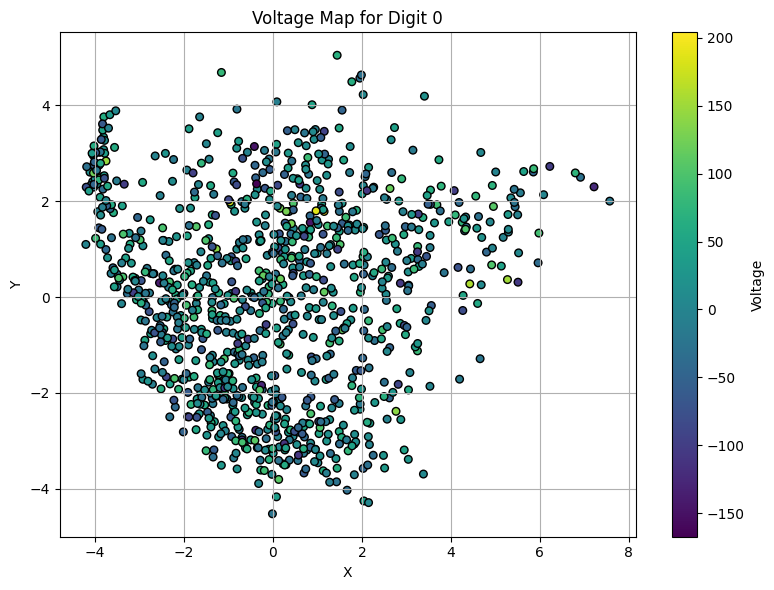

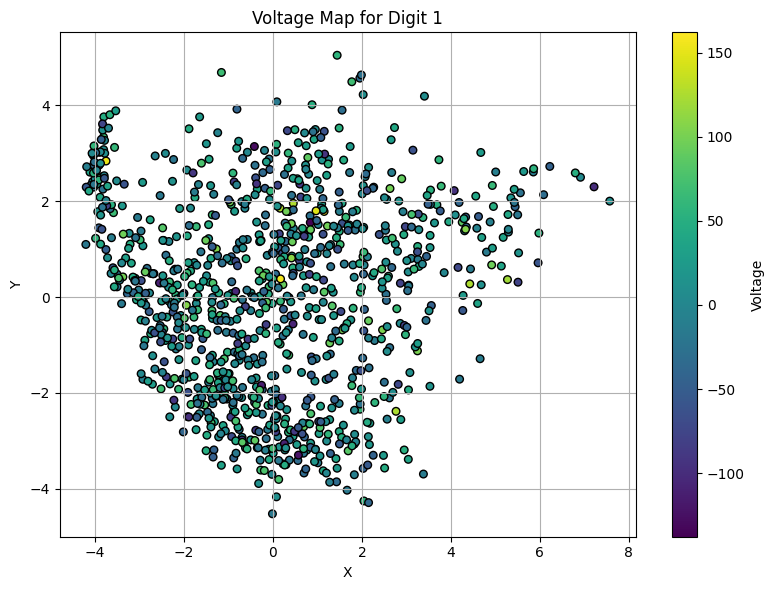

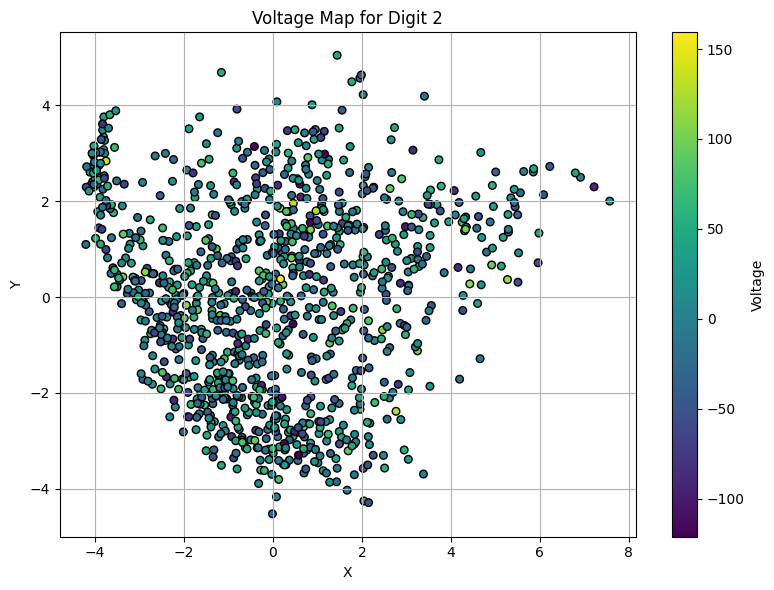

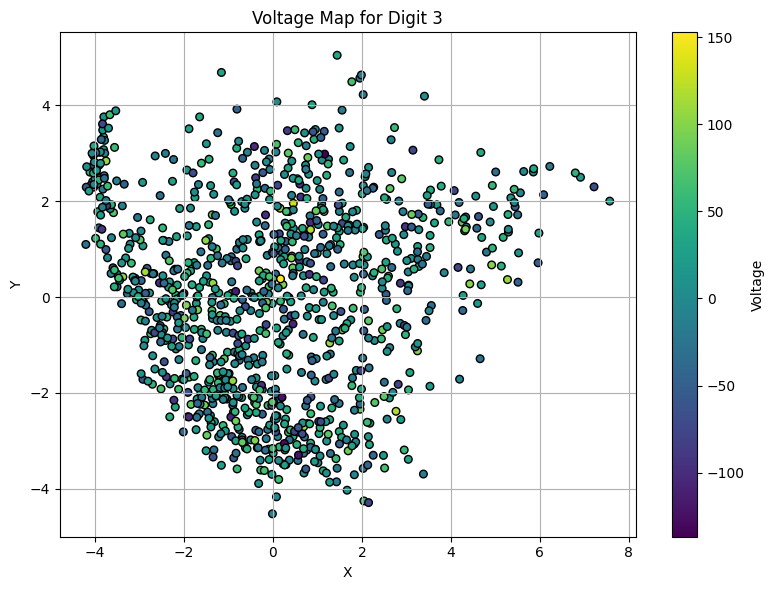

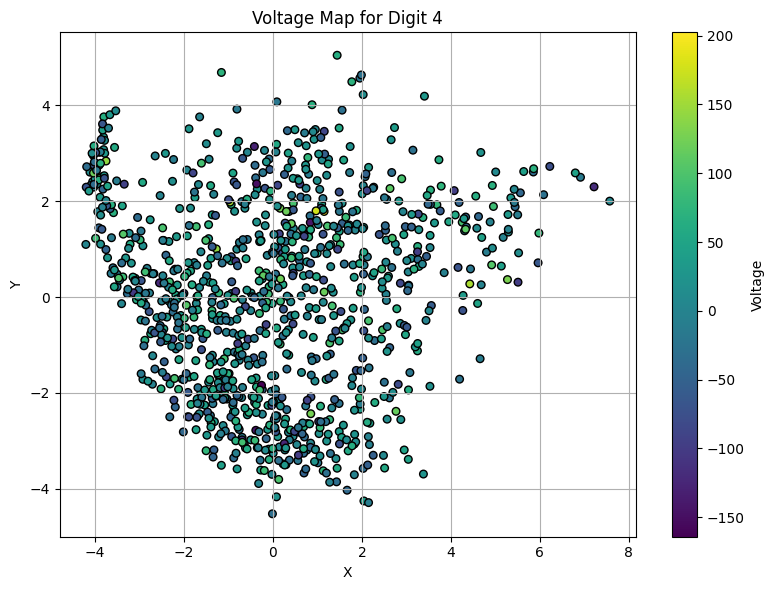

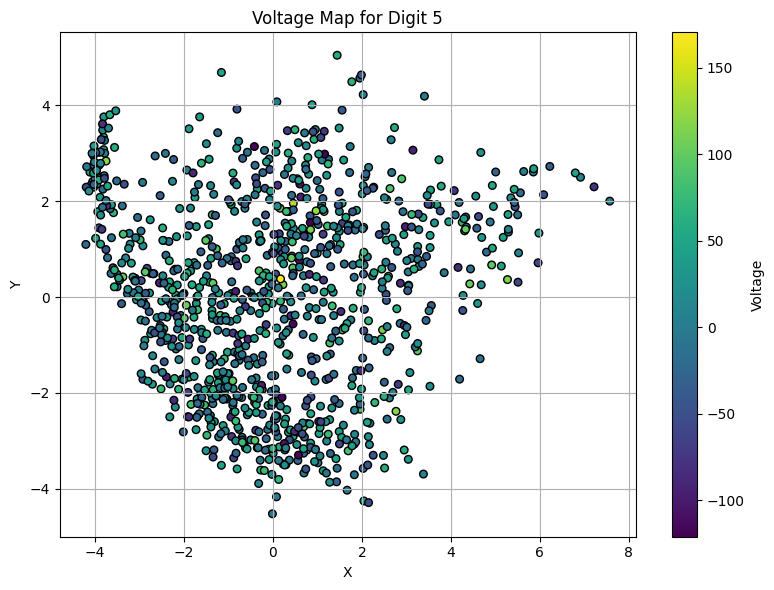

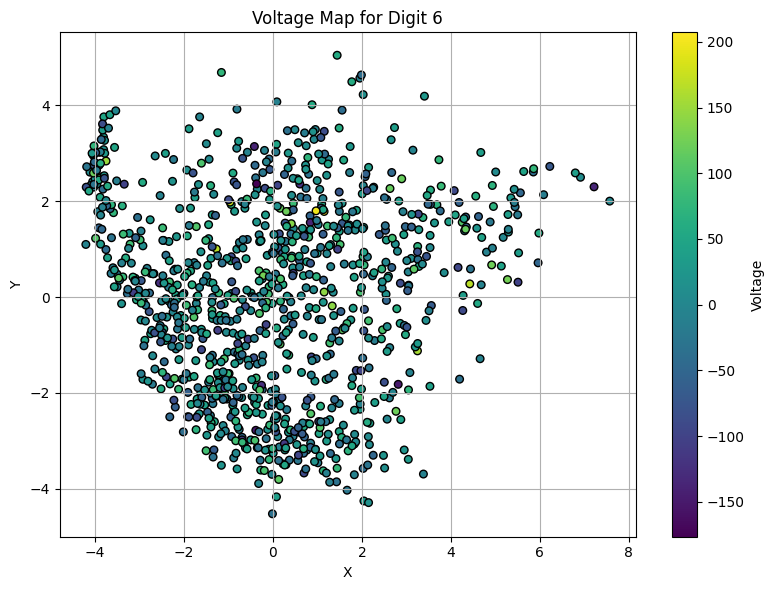

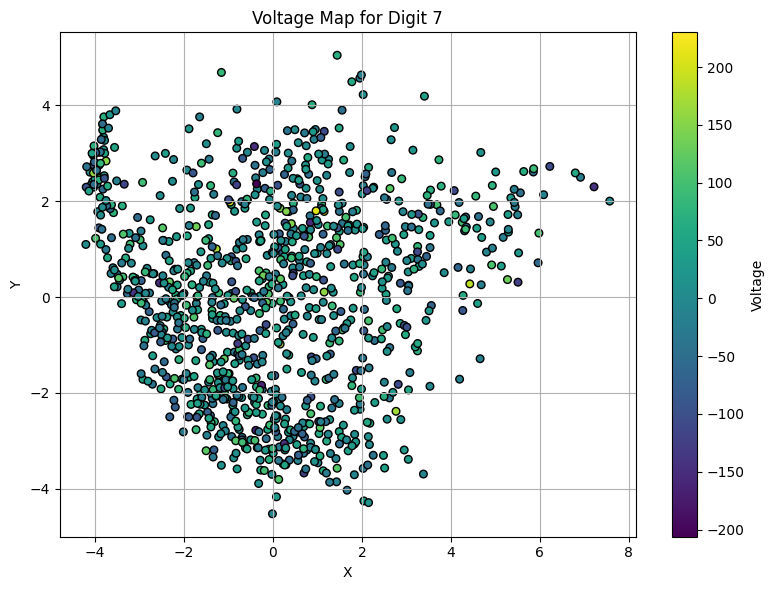

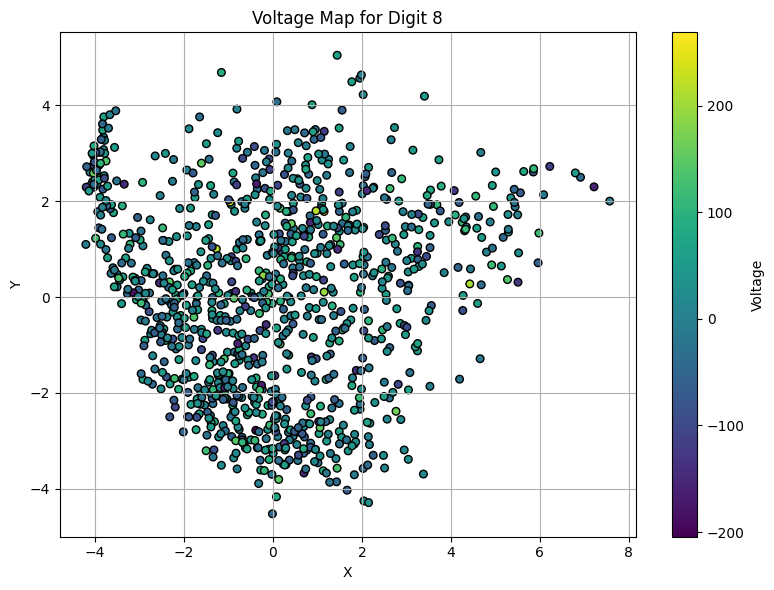

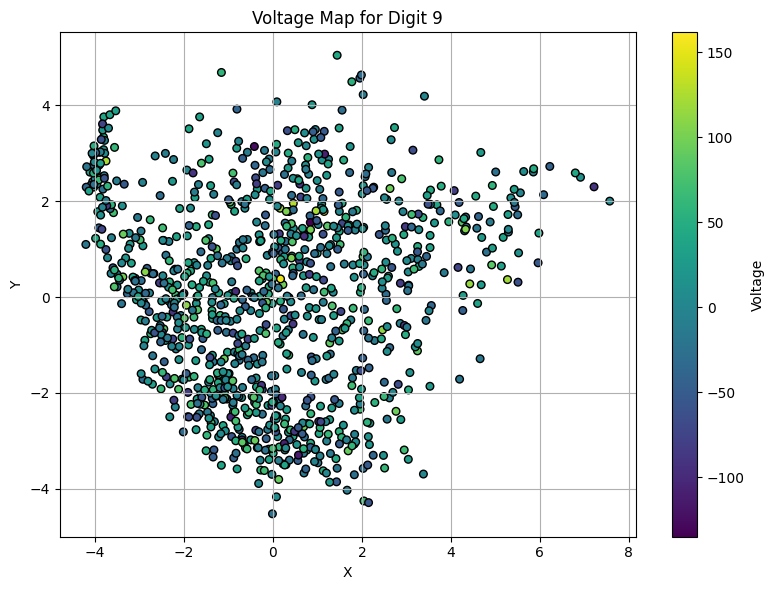

In [112]:
# Reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Visualize voltage maps for each landmark
for lm in landmarks:
    voltages = voltage_map.get_solution(landmark_index=lm.index)
    Visualization.plot_voltage_map(points=X_2d, voltages=voltages, title=f"Voltage Map for Digit {y[lm.index]}")